## Trying Out Different Models, and Building a Preprocessing Pipeline

This notebook aims to build a generic and flexible preprocessing pipeline and implements several models for classifying. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim import corpora, models
import nltk
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import keras
from keras import Input, Model, regularizers
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.engine.saving import load_model
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from pprint import pprint
from gensim import utils
import gensim.parsing.preprocessing as gsp

# nltk.download('stopwords')
# nltk.download('punkt')

Using TensorFlow backend.


## Define Pipeline Components for Feature Preprocessing:

In [2]:
# select features
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

# impute missing values
class MissingChanger(BaseEstimator, TransformerMixin):
    def __init__(self, features, constant):
        self.features = features
        self.constant = constant
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.features].fillna(self.constant)

# apply function to some features
class FeatureModifier(BaseEstimator, TransformerMixin):
    def __init__(self, features, func):
        self.features = features
        self.func = func
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xnew = X.copy()[self.features]
        Xnew = Xnew[self.features].applymap(lambda x: self.func(x))
        return np.array(Xnew)
    
# textual transformations
class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(lambda x: word_tokenize(x))
    
class StopWordsFilter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = stopwords.words('english') + list(string.punctuation)
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(lambda x: [word for word in x if word not in self.stopwords])

class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = PorterStemmer()
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(lambda x: [self.stemmer.stem(word) for word in x])

class ToStringList(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_group):
        self.features_to_group = features_to_group
        
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        string_list = []
        for index, row in X.iterrows():
            entry = []
            for feat in self.features_to_group:
                entry.extend(row[feat])
            string_list.append(" ".join(entry))
        return string_list

## Extract Medicine Inputs:

We integrate the medication data by filtering by percentage of "No" values, because the vast majority of subject only are given one or two drugs. We convert the different categorical values into a binary presentation ("No" -> 0, "Steady"/"Up"/"Down" -> 1)

In [3]:
def get_medicine_inputs(df_in: pd.DataFrame):
    df = df_in.copy()
    # categorical: {up, down, steady, no}
    medicine_all = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", 
                "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", 
                "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", 
                "glyburide.metformin", "glipizide.metformin", "glimepiride.pioglitazone", 
                "metformin.rosiglitazone", "metformin.pioglitazone"]

    # the histograms show that for majority of medicine there is little information
    medicine_thresh = []
    for med in medicine_all:
        perc_no_values = (df[med]=="No").sum() / df.shape[0]
        if perc_no_values < 0.90:  # 90% leaves 4 medicines
            medicine_thresh.append(med)

    # print(len(medicine_thresh), " drugs left after filtering: \n", medicine_thresh)
            
    to_binary = FeatureModifier(features=medicine_thresh, func=(lambda x: 0 if x == "No" else 1))
    medicine_inputs = to_binary.transform(df)
    return medicine_inputs

## Extract Numerical Inputs:

We integrate numerical inputs by applying a standard scaling. Some channels have extreme outlier values, so we apply a square-root transformation first.

In [4]:
def get_numerical_inputs(df_in: pd.DataFrame):
    df = df_in.copy()
    # some columns have extreme values:
    df['number_outpatient'] = df['number_outpatient'].apply(lambda x: np.sqrt(x + 0.5))
    df['number_emergency'] = df['number_emergency'].apply(lambda x: np.sqrt(x + 0.5))
    df['number_inpatient'] = df['number_inpatient'].apply(lambda x: np.sqrt(x + 0.5))
    
    numerical_features = ["time_in_hospital", "num_procedures", "number_outpatient", "number_emergency", 
                          "number_inpatient", "number_diagnoses","num_medications", "num_lab_procedures"]

    normalizer = Pipeline([("normalize", StandardScaler())])
    numerical_inputs = normalizer.fit_transform(df[numerical_features])
    
    return numerical_inputs

## Extract Categorical Inputs:

We integrate several categorical inputs by converting them into OneHot-vectors. Two specific inputs are first grouped by value, because they have an extremly imbalanced distribution and their value space is really large.

In [5]:
def get_categorical_inputs(df_in: pd.DataFrame):
    df = df_in.copy()
    categorical_features = ["race", "gender", "age", "max_glu_serum", "A1Cresult", "change", "diabetesMed", 
                            "admission_type_id", "admission_source_id", "discharge_disposition_id"]
        
    # admission_source_id and discharge_disposition_id are heavily imbalanced
    # and increase the input dimension too much:
    admi_type_id_keep = ["Emergency Room", "Physician Referral", 'Transfer from a hospital', 'Transfer from another health care facility']
    df[~df.admission_source_id.isin(admi_type_id_keep)] = "other"
    dis_dis_id_keep = ['Discharged to home', 'Discharged/transferred to SNF', 'Discharged/transferred to home with home health service']
    df[~df.discharge_disposition_id.isin(dis_dis_id_keep)] = "other"

    onehot_encoder = Pipeline([
        ("fill_missing", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),

    ])
    categorical_inputs = onehot_encoder.fit_transform(df[categorical_features]).toarray()
    
    return categorical_inputs

## Extract Diagnosis Inputs:

We integrate diagnosis inputs by first converting the concrete diagnosss into less specific classes. The three diagnoses are then encoded with a OneHot-vector, either as a single vector (using the Or-function) or as a three separate vectors that are concatenated into one.

In [6]:
def map_ICD9_to_class (x):
    if(x.startswith("E")):
        return 0
    if(x.startswith("V")):
        return 1
    if x.split(".")[0] == "?":
            return 0
    
    breakpoints = [0, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800]
    breakpoints.reverse()
    class_nr = len(breakpoints) - 1
    for bp in breakpoints:
        if int(x.split(".")[0]) >= bp:
            return class_nr
        class_nr = class_nr - 1
                
def get_diags_inputs(df_in: pd.DataFrame):
    """this version combines all three diagnosis in one vector, using the OR-function"""
    df = df_in.copy()
    diagnosis_codes = ["diag_1", "diag_2", "diag_3"]
    diag_in_classes = df[diagnosis_codes].applymap(map_ICD9_to_class)
    max_class_num = diag_in_classes.values.max()
    diags_inputs = np.zeros((len(df), max_class_num + 1))
    for index, row in diag_in_classes.iterrows():
        diags_inputs[index, row["diag_1"]] = 1
        diags_inputs[index, row["diag_2"]] = 1
        diags_inputs[index, row["diag_3"]] = 1
    
    return diags_inputs

def get_diags_inputs_separate(df: pd.DataFrame):
    """this version creates a separate onehot vector for each diagnosis"""
    diagnosis_codes = ["diag_1", "diag_2", "diag_3"]
    diag_in_classes = df[diagnosis_codes].applymap(map_ICD9_to_class)

    onehot_encoder_diags = Pipeline([
        ("fill_missing", SimpleImputer(strategy="constant", fill_value=0)),
        ("onehot", OneHotEncoder())
    ])
    diags_inputs = onehot_encoder_diags.fit_transform(diag_in_classes).toarray()
    
    return diags_inputs

## Extract Text Features:
We tried to integrate the textual diagnosis descrptions by converting them into TF-IDF vectors. We filter by absolute term frequency, because a vast majority of terms only occurs in a very small number of documents. Word2Vec seemed to be more useful (see next cell).

In [7]:
def get_diags_descs_tfidf(df_in: pd.DataFrame):
    df = df_in.copy()
    diagnosis_descriptions = ["diag_1_desc", "diag_2_desc", "diag_3_desc"]
    diags_descs_to_tfidf = Pipeline([
        ("select_textual_features", Selector(diagnosis_descriptions)),
        ("add_missing_class", MissingChanger(diagnosis_descriptions, "")),
        ("tokenize", Tokenizer()),
        ("filter_stop_words", StopWordsFilter()),
        ("perform_stemming", Stemmer()),
        ("to_string_list", ToStringList(diagnosis_descriptions)),
        # distribution plot of word count revealed that the vast majority of word only 
        # appears in a very small number of docs, that's why we filter them out
        ('vectorizer', TfidfVectorizer(min_df=400, max_df=int(len(df) * 0.7))),
    ])
    
    tfidf_out = diags_descs_to_tfidf.fit_transform(df).toarray()
    
    for channel in range(tfidf_out.shape[1]):
        tfidf_out[:, channel] -= np.mean(tfidf_out[:, channel])
        tfidf_out[:, channel] /= np.std(tfidf_out[:, channel])

    return tfidf_out

We use a different pipeline and train a Word2Vec embedding on the diagnosis descriptions. We then transform the concatenated 3 descriptions into a single vector by averaging the embedded output vectors of each word.

In [8]:
class AllInOneTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.filters = [
            gsp.strip_tags, 
            gsp.strip_punctuation,
            gsp.strip_multiple_whitespaces,
            gsp.strip_numeric,
            gsp.remove_stopwords, 
            gsp.strip_short, 
            gsp.stem_text
        ]
    def fit(self, X, y=None):
        return self
    
    def do_cleaning(self, x, filters):
        x = x.lower()
        x = utils.to_unicode(x)
        for f in filters:
            x = f(x)
        return x
    
    def transform(self, X):
        return X.apply(lambda x: self.do_cleaning(x, self.filters))
    

class FormatFixer(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_group):
        self.features_to_group = features_to_group
        
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        string_result = ""
        for feat in self.features_to_group:
            string_result = string_result + " " + X[feat]
        return string_result
    
    
class ShortWordRemover(BaseEstimator, TransformerMixin):
    def __init__(self, min_length):
        self.min_length=min_length
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.apply(lambda x: [word for word in x if len(word) >= self.min_length])
    
    
def get_text_features_doc2vec(df_in: pd.DataFrame, embedding_size: int):
    df = df_in.copy()
    diagnosis_descriptions = ["diag_1_desc", "diag_2_desc", "diag_3_desc"]
    pipe = Pipeline([
            ("select_textual_features", Selector(diagnosis_descriptions)),
            ("add_missing_class", MissingChanger(diagnosis_descriptions, "")),
            ("fix_format", FormatFixer(diagnosis_descriptions)),
            ("all_in_one", AllInOneTransformer()),         
            ("to_list_of_words", Tokenizer()),
            ("short_words_remover", ShortWordRemover(min_length=3))
        ])

    transformed_text = pipe.fit_transform(df)
    model = Word2Vec(transformed_text, size=embedding_size)
    vocab = list(model.wv.vocab)
    text_features_out = np.zeros((len(df), model.wv[vocab[0]].shape[0]))

    for i in range(len(df)):
        x = transformed_text[i]
        text_features_out[i, :] = sum([model.wv[word] for word in x if word in model.wv.vocab]) / sum([1 if word in model.wv.vocab else 0 for word in x])
        
    return text_features_out

## Combine Inputs:

The following functions call all the previous helper functions and concatenate the output arrays into a single result. Because processing the individual column families separately might prove to be useful, we also provide a function that splits the single array into column slices.

In [9]:
def get_all_inputs(df_in: pd.DataFrame):
    df = df_in.copy()
    # return all inputs as single np array
    numerical_inputs = get_numerical_inputs(df)
    categorical_inputs = get_categorical_inputs(df)
    medicine_inputs = get_medicine_inputs(df)
    diags_inputs = get_diags_inputs(df)
    # diags_descs = get_diags_descs_tfidf(df)
    diags_descs = get_text_features_doc2vec(df, embedding_size=50)
    
    neurons_numerical = numerical_inputs.shape[1]
    neurons_categorical = categorical_inputs.shape[1]
    neurons_medicine = medicine_inputs.shape[1]
    neurons_diags = diags_inputs.shape[1]
    neurons_diags_descs = diags_descs.shape[1]

    all_inputs = np.concatenate((numerical_inputs, categorical_inputs, medicine_inputs, diags_inputs, diags_descs), axis=1)
    
    return all_inputs, (neurons_numerical, neurons_categorical, neurons_medicine, neurons_diags, neurons_diags_descs)

def convert_to_multi_input(data, input_sizes):
    # turn single np array into column-families:
    temp_data = []
    column_idx = 0
    for i in input_sizes:
        temp_data.append(data[:, column_idx : column_idx + i])
        column_idx += i        
    return temp_data

## Read Input and Build Matrix:
Because the preprocessing may produce different output dimensions, depending on the absence of certain values, we first combine all data (i.e. train-, val-, and test-set), extract our features and then divide the data again.

Please note that we still strictly obey the separation of train-, val- and test-data for all purposes of model-fitting !

In [10]:
X_train = pd.read_csv("../input/diab_train.csv", index_col=0)
# balance train data:
positives = X_train[X_train["readmitted"] == 1]
negatives = X_train[X_train["readmitted"] == 0]

balance_both = False

if balance_both:
    oversampled = positives.sample(int(0.5 * len(X_train) - len(positives)), replace=True)
    undersampled = negatives.sample(int(0.5 * len(X_train)), replace=True)
    X_train = pd.concat([positives, oversampled, undersampled]).reset_index(drop=True)
else:
    # simply oversample positives
    oversampled = positives.sample(len(negatives) - len(positives), replace=True)
    X_train = pd.concat([positives, oversampled, negatives]).reset_index(drop=True)
    
Y_train = X_train["readmitted"]
X_train = X_train.drop(columns="readmitted")
len_train = len(X_train)

X_val = pd.read_csv("../input/diab_validation.csv", index_col=0)
Y_val = X_val["readmitted"]
X_val = X_val.drop(columns="readmitted")
len_val = len(X_val)

X_test  = pd.read_csv("../input/diab_test.csv", index_col=0)
Y_test = X_test["readmitted"]
X_test = X_test.drop(columns="readmitted")
len_test = len(X_test)

# extract features, build data matrix
X_all = pd.concat([X_train, X_val, X_test]).reset_index(drop=True)
all_inputs, input_sizes = get_all_inputs(X_all)

train_inputs = all_inputs[: len_train]
val_inputs = all_inputs[len_train: len_train + len_val]
test_inputs = all_inputs[len_train + len_val: ]

train_outputs = Y_train.values
val_outputs = Y_val.values
test_outputs = Y_test.values

print("The train input array has shape ", train_inputs.shape)
print("and consists of the following column sub-groups: ", input_sizes)


The train input array has shape  (7242, 132)
and consists of the following column sub-groups:  (8, 53, 4, 17, 50)


## Multi-Input MLP:

The idea here is that the specific column families might be "prefiltered" inside an MLP, by squeezing the input through a relativly low number of neurons, before combining them.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 53)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 17)           0                                            
____________________________________________________________________________________________

Epoch 55/60
 - 0s - loss: 0.5594 - acc: 0.7126 - val_loss: 0.6718 - val_acc: 0.6200
Epoch 56/60
 - 0s - loss: 0.5594 - acc: 0.7129 - val_loss: 0.6718 - val_acc: 0.6200
Epoch 57/60
 - 0s - loss: 0.5594 - acc: 0.7128 - val_loss: 0.6718 - val_acc: 0.6200
Epoch 58/60
 - 0s - loss: 0.5594 - acc: 0.7128 - val_loss: 0.6718 - val_acc: 0.6205
Epoch 59/60
 - 0s - loss: 0.5594 - acc: 0.7124 - val_loss: 0.6718 - val_acc: 0.6205
Epoch 60/60
 - 0s - loss: 0.5593 - acc: 0.7128 - val_loss: 0.6718 - val_acc: 0.6205


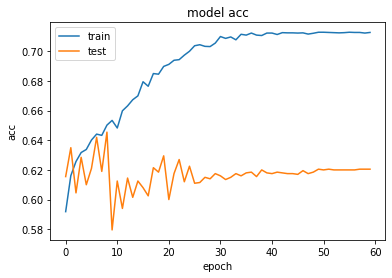

AUC score is:  0.656811725631588
ACC score is:  0.634


In [11]:
def get_multi_input_model(neurons_numerical, neurons_categorical, neurons_medicine, neurons_diags, neurons_text):
    numer_input = Input(shape=(neurons_numerical, ))
    numer_pre = Dense(neurons_numerical, activation='tanh')(numer_input)
        
    categ_input = Input(shape=(neurons_categorical, ))
    categ_pre = Dense(int(neurons_categorical / 6), activation='tanh')(categ_input)
    
    medic_input = Input(shape=(neurons_medicine, ))
    medic_pre = Dense(4, activation='tanh')(medic_input)
    
    diags_input = Input(shape=(neurons_diags, ))
    diags_pre = Dense(int(neurons_diags / 2), activation='tanh')(diags_input)
    
    text_input = Input(shape=(neurons_text, ))
    # text_pre = Dropout(rate=0.2)(text_input)
    text_pre = Dense(20, activation='tanh')(text_input)

    main = keras.layers.concatenate([numer_pre, categ_pre, medic_pre, diags_pre, text_pre], axis=1)
    main = Dense(25, activation='tanh')(main)
    main = Dense(25, activation='tanh')(main)
    m_out = Dense(1, activation='sigmoid')(main)
    
    m_model = Model(inputs=[numer_input, categ_input, medic_input, diags_input, text_input], outputs=[m_out])
    m_model.compile(loss=keras.losses.binary_crossentropy,
                    optimizer=keras.optimizers.Adam(lr=0.002),
                    metrics=['acc'])
        
    return m_model

multi_model = get_multi_input_model(*input_sizes)
multi_model.summary()
file_path_multi = "multi_input_mlp_checkpoint.h5"

checkpoint = ModelCheckpoint(file_path_multi, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=1000, verbose=0)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=5, factor=0.5, verbose=0)
callbacks_list = [checkpoint, early, redonplat]

history = multi_model.fit(convert_to_multi_input(train_inputs, input_sizes),
                          train_outputs,
                          epochs=60,
                          batch_size=128,
                          verbose=2,
                          callbacks=callbacks_list,
                          validation_data=(convert_to_multi_input(val_inputs, input_sizes), val_outputs))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

multi_model = load_model(file_path_multi)
y_pred_test = multi_model.predict(convert_to_multi_input(test_inputs, input_sizes))

print("AUC score is: ", metrics.roc_auc_score(test_outputs, y_pred_test))
y_pred_test = (y_pred_test > 0.5).astype(np.int8)
print("ACC score is: ", metrics.accuracy_score(test_outputs, y_pred_test))

## Finetuned MLP

Simple MLP, finetuned parameters.

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 132)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 132)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 30)                3990      
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 5,881
Trainable params: 5,881
Non-trainable params: 0
_________________________________________________________

Epoch 84/100
 - 0s - loss: 0.6215 - acc: 0.6603 - val_loss: 0.6624 - val_acc: 0.6080
Epoch 85/100
 - 0s - loss: 0.6222 - acc: 0.6591 - val_loss: 0.6614 - val_acc: 0.6105
Epoch 86/100
 - 0s - loss: 0.6206 - acc: 0.6636 - val_loss: 0.6622 - val_acc: 0.6095
Epoch 87/100
 - 0s - loss: 0.6209 - acc: 0.6609 - val_loss: 0.6608 - val_acc: 0.6100
Epoch 88/100
 - 0s - loss: 0.6197 - acc: 0.6651 - val_loss: 0.6622 - val_acc: 0.6080
Epoch 89/100
 - 0s - loss: 0.6214 - acc: 0.6629 - val_loss: 0.6618 - val_acc: 0.6090
Epoch 90/100
 - 0s - loss: 0.6222 - acc: 0.6618 - val_loss: 0.6615 - val_acc: 0.6120
Epoch 91/100
 - 0s - loss: 0.6203 - acc: 0.6635 - val_loss: 0.6616 - val_acc: 0.6090
Epoch 92/100
 - 0s - loss: 0.6231 - acc: 0.6584 - val_loss: 0.6610 - val_acc: 0.6115
Epoch 93/100
 - 0s - loss: 0.6236 - acc: 0.6592 - val_loss: 0.6614 - val_acc: 0.6095
Epoch 94/100
 - 0s - loss: 0.6209 - acc: 0.6631 - val_loss: 0.6616 - val_acc: 0.6095
Epoch 95/100
 - 0s - loss: 0.6216 - acc: 0.6588 - val_loss: 0.661

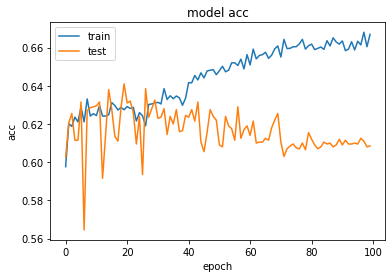

AUC score is:  0.6644197206083471
ACC score is:  0.6185


In [12]:
def get_model(input_size: int):
    m_input = Input(shape=(input_size, ))
    main = Dropout(rate=0.05)(m_input)
    main = Dense(30, kernel_regularizer=regularizers.l2(0.006), activation='tanh')(main)
    main = Dense(30, activation='tanh')(main)
    main = Dense(30, activation='tanh')(main)
    m_out = Dense(1, activation='sigmoid')(main)
    
    m_model = Model(inputs=[m_input], outputs=[m_out])
    m_model.compile(loss=keras.losses.binary_crossentropy,
                    optimizer=keras.optimizers.Adam(lr=0.005),
                    metrics=['acc'])
    
    m_model.summary()
    
    return m_model

model = get_model(input_size=train_inputs.shape[1])
file_path = "simple_mlp_checkpoint.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=1000, verbose=0)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=10, factor=0.5, verbose=0)
callbacks_list = [checkpoint, early, redonplat]

history = model.fit(train_inputs,
                    train_outputs,
                    epochs=100,
                    batch_size=128,
                    verbose=2,
                    callbacks=callbacks_list,
                    validation_data=(val_inputs, val_outputs))

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model = load_model(file_path)
y_pred_test = model.predict(test_inputs)

print("AUC score is: ", metrics.roc_auc_score(test_outputs, y_pred_test))
y_pred_test = (y_pred_test > 0.5).astype(np.int8)
print("ACC score is: ", metrics.accuracy_score(test_outputs, y_pred_test))

## Try Various Classifiers:

In [13]:
random_forest = RandomForestClassifier()
random_forest.fit(train_inputs, train_outputs)
y_pred_test = random_forest.predict(test_inputs)
y_pred_test = (y_pred_test > 0.5).astype(np.int8)
print("Random Forest: ACC score is ", metrics.accuracy_score(test_outputs, y_pred_test))


logreg=LogisticRegression()
logreg.fit(train_inputs, train_outputs)
y_pred_test = logreg.predict(test_inputs)
y_pred_test = (y_pred_test > 0.5).astype(np.int8)
print("Logistic Regression: ACC score is ", metrics.accuracy_score(test_outputs, y_pred_test))

svclassifier = SVC(kernel='poly')
svclassifier.fit(train_inputs, train_outputs)
y_pred_test = svclassifier.predict(test_inputs)
y_pred_test = (y_pred_test > 0.5).astype(np.int8)
print("SVC with Poly-Kernel: ACC score is ", metrics.accuracy_score(test_outputs, y_pred_test))
svclassifier = SVC(kernel='rbf')
svclassifier.fit(train_inputs, train_outputs)
y_pred_test = svclassifier.predict(test_inputs)
y_pred_test = (y_pred_test > 0.5).astype(np.int8)
print("SVC with RBF-Kernel: ACC score is ", metrics.accuracy_score(test_outputs, y_pred_test))

Random Forest: ACC score is  0.626
Logistic Regression: ACC score is  0.629


/home/alunia/anaconda3/envs/ml4h_task2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVC with Poly-Kernel: ACC score is  0.6415
SVC with RBF-Kernel: ACC score is  0.6335


Random Forests seem to be the worst out of the three classifiers. SVM and Logistic Regression achieve roughly the same ACC scores.